## Adding IFMR Scatter

**Input**: Model parameters + IFMR parameters

**Method**: 

- Parameters in Cummings+18 have uncertainties 
- Initial mass Mini calculated from final mass Mf with the IFMR also has an uncertainty
- Our N values are calculated for the deterministic IFMR
- To model this scatter, we need to take into account that different rows can contribute to a given row in the stellar assemblies' table. 
- Contribution weights of each k-th row to the given i-th row is defined by Mini[i], sigma_Mini[i] and Mini[k].

**Output**: Population tables with new N column, predicted Hess diagram

In [1]:
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

from helpers import IFMRHandler
from jjmodel.input_ import p, a, inp
from jjmodel.mwdisk import local_run
from helpers import (IMFHandler, IFMRHandler, SFRHandler, 
                     PopHandler, HessConstructor, extract_model_tables)


Parameter file(s) : ok.
Number of parameters =  66 , among them technical =  7

 p(run_mode=0, out_dir='new_metgrid', out_mode=1, nprocess=4, Rsun=8.2, zsun=20, zmax=2000, dz=2, sigmad=29.3, sigmat=4.9, sigmag1=2.0, sigmag2=11.0, sigmadh=51.9, sigmash=0.47, td1=0, td2=7.8, dzeta=0.8, eta=5.6, pkey=1, tt1=0.1, tt2=4, gamma=2, beta=3.5, imfkey=0, a0=1.31, a1=1.5, a2=2.88, a3=2.28, m0=0.49, m1=1.43, m2=6.0, dFeHdt=0, n_FeHdt=1, fehkey=0, FeHd0=-0.7, FeHdp=0.29, rd=0.34, q=-0.72, FeHt0=-0.94, FeHtp=0.04, rt=0.77, t0=0.97, FeHsh=-1.5, dFeHsh=0.4, n_FeHsh=5, alpha=0.375, sige=26.0, sigt=45, sigdh=140, sigsh=100, sigmap=array([3.5, 1.3]), tpk=array([10. , 12.5]), dtp=array([0.7 , 0.25]), sigp=array([26.3, 12.6]))

Parameters checked: 0 Reminders, 0 Warnings, 0 Errors.

Configuration finished:  0h 0m 0.0s


In [2]:
# Define parameters
# -----------------

labels = ['d','t','sh'] # MW components to model
mode_iso = 'Padova'     # main isochrones pack 
FeH_scatter = 0.07      # dex, scatter for AMR
Nmet_dt = 7             # number of single-metallicity subpopulations for applying AMR scatter
mode = 'ms+wd'          # stars to model: 'ms+wd' or 'wd'
radius = 50             # pc, local sphere
mag_range = [[-0.4,1.65],[-1,18]] # range for Hess diagram
mag_step = [0.02,0.2]             # resolution 
mag_smooth = [0.06,0.8]           # smoothing

hess_ref = np.loadtxt('data/hess/hess_tot.txt') # Data


In [3]:

ifmr_handler = IFMRHandler()
imf_handler = IMFHandler(p)
sfr_handler = SFRHandler(p, a, inp)
pop_handler = PopHandler(p, a, inp)
constructor = HessConstructor(radius, p, a)

In [14]:
# Generate tables 
# ---------------

# Run the model 
out = local_run(p,a,inp,save=False,status_progress=False)
inp_tabs = extract_model_tables(out,inp)

# Generate stellar assemblies
imf_ref, (mass_binsc, IMF_ref) = imf_handler.create_reference_imf()

pop_kwargs = {'FeH_scatter':FeH_scatter,
              'Nmet_dt':Nmet_dt,
              'Nmet_sh':Nmet_dt
              }
pop_tabs = pop_handler.create_reference_pop_tabs(imf_ref,mode_iso,wd=mode,FeH_scatter=0.07,Nmet_dt=7)
indt, indm = pop_handler.get_age_mass_idx(pop_tabs,mass_binsc)

# Find WD indices
ind_da, ind_db = pop_handler.get_wd_idx(pop_tabs)
ind_wd = {label: [ind_da[label],ind_db[label]] for label in pop_tabs.keys()}



Stellar population synthesis for R = 8.2 kpc:
Warning. Some of modeled metallicities (halo) are outside of Padova metallicity range [-2.2,0.5], i.e., the adopted best isochrones may be not representative.
	thin disk	thick disk	halo


### Considerations on optimization 

Stellar assemblies' tables consist of many isochrones stacked together. 
All WD isochrones are calculated for the **same initial mass grid**. Thus, the number of **unique values** of Mini and sigma_Mini is much less than the total number of rows in each table. 

The IFMR scatter can be applied to the table collapsed over mass grid - this will significantly decrease computation time (x10 or more). The important part is then to redistribute new N values across the initial same-mass rows using the proper weights. 

Below we compare two approaches: 
- **ifmr_handler.apply_ifmr_scatter_poptabs_exact()**: exact IFMR scatter application - to all rows 
- **ifmr_handler.apply_ifmr_scatter_poptabs_reduced()**: reduced approach - to collapsed table with subsequent redistribution of updated N over the summed rows

In [15]:
pop_tabs = ifmr_handler.add_sigma_mini_column(pop_tabs,ind_wd)

In [16]:
# Apply IFMR scatter (compare calc times!)
# ----------------------------------------

pop_tabs_sm1 = ifmr_handler.apply_ifmr_scatter_poptabs_exact(pop_tabs,ind_wd)

In [17]:
pop_tabs_sm2 = ifmr_handler.apply_ifmr_scatter_poptabs_reduced(pop_tabs,ind_wd)

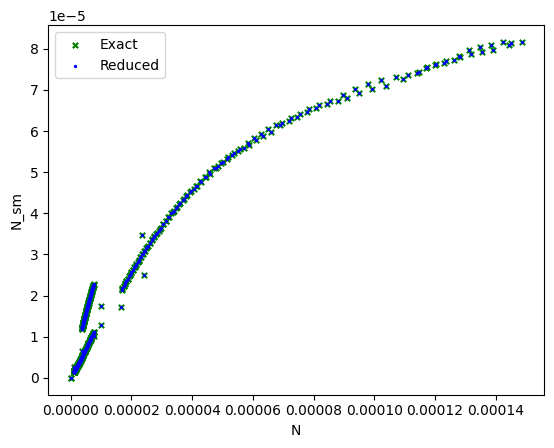

In [18]:
# Check how N_sm values look for a fixed age in the two new tables
# ----------------------------------------------------------------

comp = 'd'      # d, t, sh = thin disk, thick disk or halo
wd_type = 0     # 0 = DA, 1 = DB
age = 5         # Gyr, test age 

wd_rows = ind_wd[comp][wd_type]

ind_array = np.array(np.round(pop_tabs_sm2[comp]['age'][wd_rows],3)//0.025,dtype=int)
ind_age = np.where(ind_array==int(age//0.025))[0]

age_rows = wd_rows[ind_age]

plt.figure()
plt.scatter(pop_tabs_sm1[comp]['N'][age_rows],pop_tabs_sm1[comp]['N_sm'][age_rows],
            c='g',s=15,marker='x',label='Exact')
plt.scatter(pop_tabs_sm2[comp]['N'][age_rows],pop_tabs_sm2[comp]['N_sm'][age_rows],
            c='b',s=2,label='Reduced')
plt.xlabel('N')
plt.ylabel('N_sm')
plt.legend(loc=2)

In [19]:
# Choose tables for Hess prediction 
# Rename new column to N such that it will b used to calculate Hess diagram
# --------------------------------------------------------------------------
pop_tabs_sm = pop_tabs_sm2
for label in labels:
    pop_tabs_sm[label]['N'] = pop_tabs_sm[label]['N_sm']

In [20]:
# Predict Hess diagram
# ---------------------

shift = 0 # mag, test color shift
hess = constructor.generate_hess(pop_tabs_sm,indt['d'],inp_tabs,
                                 mag_range,mag_step,mag_smooth,
                                 color_shift=shift)

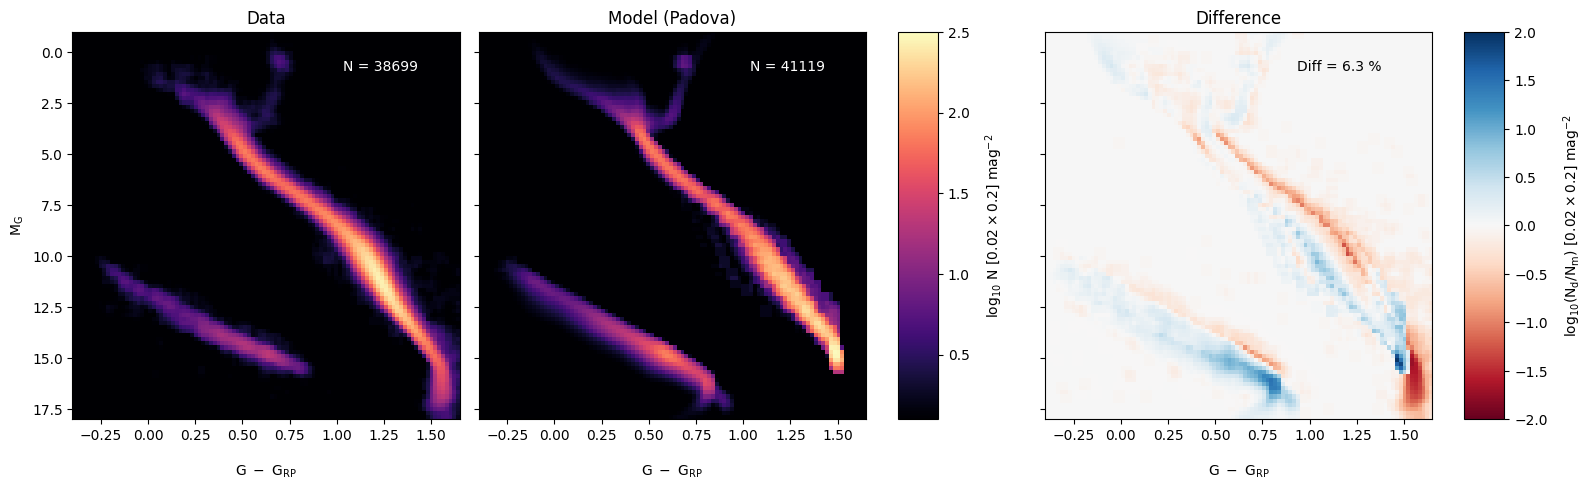

In [21]:
# Plot model and data
#--------------------

Ntot_d = int(round(sum(sum(hess_ref)),0))
Ntot_m = int(round(sum(sum(hess)),0))

fig, ax = plt.subplots(1,3,figsize=(16,5.5),sharey=True)

# Data
im1 = ax[0].imshow(np.log10(hess_ref+1),interpolation=None,cmap=mpl.colormaps['magma'],
               extent=[mag_range[0][0],mag_range[0][1],mag_range[1][1],mag_range[1][0]],
               vmin=0.1,vmax=2.5)
ax[0].text(0.7,0.9,'N = '+str(Ntot_d),color='w',transform=ax[0].transAxes)
ax[0].set_aspect(abs((mag_range[0][1]-mag_range[0][0])/(mag_range[1][1]-mag_range[1][0])))
ax[0].set_title('Data')
ax[0].set_xlabel(r'$\mathrm{G \ - \ G_{RP}}$',labelpad=15)
ax[0].set_ylabel(r'$\mathrm{M_G}$')

# Model
ax[1].imshow(np.log10(hess+1),interpolation=None,cmap=mpl.colormaps['magma'],
               extent=[mag_range[0][0],mag_range[0][1],mag_range[1][1],mag_range[1][0]],
               vmin=0.1,vmax=2.5)
ax[1].set_aspect(abs((mag_range[0][1]-mag_range[0][0])/(mag_range[1][1]-mag_range[1][0])))
ax[1].text(0.7,0.9,'N = '+str(Ntot_m),color='w',transform=ax[1].transAxes)
ax[1].set_title('Model (' + mode_iso + ')')
#ax[1].set_title('Model (Montreal)')
ax[1].set_xlabel(r'$\mathrm{G \ - \ G_{RP}}$',labelpad=15)


fig.subplots_adjust(left=0.05,wspace=0.05,right=0.8,top=0.93)
pos = ax[1].get_position()
cax = fig.add_axes([pos.x0+pos.width+0.02,pos.y0,0.025,pos.height])
cbar = fig.colorbar(im1,cax=cax,orientation='vertical')
cbar.set_label(r'$\mathrm{log_{10} \ N \ [' + str(mag_step[0]) +
               r'\times' + str(mag_step[1]) + r'] \ mag^{-2}}$',labelpad=10)

# Difference
diff = (np.log10(hess+1) - np.log10(hess_ref+1))#/(hess + 1)

pos_x2 = ax[2].get_position()
ax[2].set_position([pos_x2.x0+0.1,pos_x2.y0,pos_x2.width,pos_x2.height])

im2 = ax[2].imshow(diff,interpolation=None,cmap=mpl.colormaps['RdBu'],
               extent=[mag_range[0][0],mag_range[0][1],mag_range[1][1],mag_range[1][0]],
               vmin=-2.0,vmax=2.0)
ax[2].text(0.65,0.9,'Diff = '+str(np.round(100*(Ntot_m-Ntot_d)/Ntot_d,1))+' %',
           color='k',transform=ax[2].transAxes)
ax[2].set_aspect(abs((mag_range[0][1]-mag_range[0][0])/(mag_range[1][1]-mag_range[1][0])))
ax[2].set_xlabel(r'$\mathrm{G \ - \ G_{RP}}$',labelpad=15)
ax[2].set_title('Difference')

pos2_new = ax[2].get_position()
cax = fig.add_axes([pos2_new.x0+pos2_new.width+0.02,pos2_new.y0,0.025,pos2_new.height])
cbar = fig.colorbar(im2,cax=cax,orientation='vertical')
cbar.set_label(r'$\mathrm{log_{10}(N_{d}/N_{m}) \ [' + str(mag_step[0]) +
               r'\times' + str(mag_step[1]) + r'] \ mag^{-2}}$',labelpad=10)

#plt.savefig('m2d_montreal_newmet_' + mode_iso + '_' + mode + '_sf' + str(shift) + '_ifmr_scatter.png')
#plt.savefig('m2d_montreal_newmet_' + mode + '_sf' + str(shift) + '_ifmr_scatter.png')


## Conclusions

- Reduced approach of applying IFMR scatter is identical to the exact one and can be safely used. 

- Calculation time is reduced by **x1000**!

- Adding IFMR makes Wd sequence thicker but essentially does not affect star counts. So these is no need to include it into MCMC modelling
